Epoch 1/100
17/17 [==============================] - 11s 411ms/step - loss: 2.3035 - mae: 1.0486 - val_loss: 1.4200 - val_mae: 0.7703
Epoch 2/100
17/17 [==============================] - 2s 141ms/step - loss: 1.4912 - mae: 0.8028 - val_loss: 1.3548 - val_mae: 0.7656
Epoch 3/100
17/17 [==============================] - 2s 141ms/step - loss: 1.3984 - mae: 0.7852 - val_loss: 1.2998 - val_mae: 0.7627
Epoch 4/100
17/17 [==============================] - 2s 141ms/step - loss: 1.3326 - mae: 0.7749 - val_loss: 1.2459 - val_mae: 0.7587
Epoch 5/100
17/17 [==============================] - 2s 144ms/step - loss: 1.2789 - mae: 0.7712 - val_loss: 1.2014 - val_mae: 0.7554
Epoch 6/100
17/17 [==============================] - 2s 142ms/step - loss: 1.2234 - mae: 0.7616 - val_loss: 1.1548 - val_mae: 0.7490
Epoch 7/100
17/17 [==============================] - 2s 142ms/step - loss: 1.1380 - mae: 0.7508 - val_loss: 1.1165 - val_mae: 0.7443
Epoch 8/100
17/17 [==============================] - 2s 141ms/step -

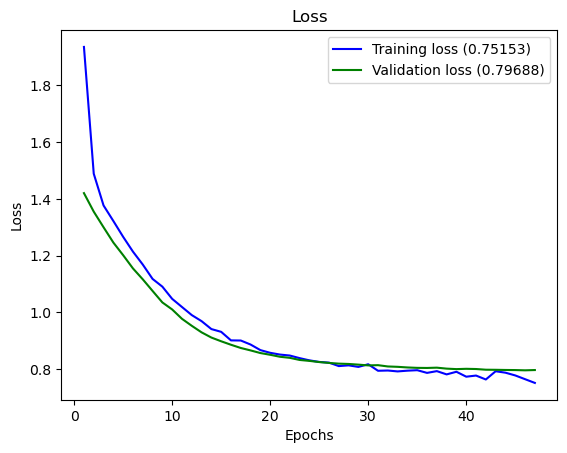

In [1]:
from __future__ import print_function
import numpy as np
import random
import pandas as pd
from scipy import stats
import sys, os
import logging
import tensorflow as tf
from keras import layers
from keras import regularizers
from keras.models import Model
from keras.models import Sequential
from keras.layers import *
from keras.regularizers import l1,l2, L1L2
from sklearn.metrics.pairwise import cosine_similarity
import keras
import keras.utils.np_utils as kutils
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,Callback,ModelCheckpoint,ReduceLROnPlateau
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import datasets, linear_model
import itertools

import matplotlib.pyplot as plt
import math as m
import keras.backend as K
import sklearn

cur="h"
IMP_input =  "data/"+cur+".txt"

def indices_to_one_hot(data,nb_classes):
	
	targets = np.array(data).reshape(-1)
	
	return np.eye(nb_classes)[targets]

nb_classes = 4

data = pd.read_csv(IMP_input, sep='\t',header=0,na_values='nan')
SNP = data[data.columns[4:]]
SNP = SNP.apply(pd.to_numeric, errors='coerce')
pheno = data[data.columns[1]] 
pheno = pheno.apply(pd.to_numeric, errors='coerce')
folds = data[data.columns[0]] 
folds = folds.apply(pd.to_numeric, errors='coerce')
arr = np.empty(shape=[SNP.shape[0],SNP.shape[1] , nb_classes])
for i in range(0,SNP.shape[0]):
    arr[i] = indices_to_one_hot(pd.to_numeric(SNP.iloc[i],downcast='signed'), nb_classes)

def resnet(input):

    inputs = Input(shape=(input.shape[1],nb_classes))


    x = Conv1D(10,4,padding='same',activation = 'linear',kernel_initializer = 'TruncatedNormal', kernel_regularizer=regularizers.l2(0.1),bias_regularizer = regularizers.l2(0.01))(inputs)
    x = Conv1D(10,20,padding='same',activation = 'linear', kernel_initializer = 'TruncatedNormal',kernel_regularizer=regularizers.l2(0.1),bias_regularizer = regularizers.l2(0.01))(x)
    x = Dropout(0.75)(x)
    shortcut = Conv1D(10,4,padding='same',activation = 'linear',kernel_initializer = 'TruncatedNormal', kernel_regularizer=regularizers.l2(0.1),bias_regularizer = regularizers.l2(0.01))(inputs)
    x = layers.add([shortcut,x])
    x = Conv1D(10,4,padding='same',activation = 'linear',kernel_initializer = 'TruncatedNormal', kernel_regularizer=regularizers.l2(0.1),bias_regularizer = regularizers.l2(0.01))(x)
    x = Dropout(0.75)(x)
    x = Flatten()(x)
    x = Dropout(0.75)(x)
    outputs = Dense(1,activation = isru,bias_regularizer = regularizers.l2(0.01),kernel_initializer = 'TruncatedNormal',name = 'out')(x)
    model = Model(inputs = inputs,outputs = outputs)
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(lr=0.001),metrics=['mae'])
    return model

def compile_saliency_function(model):

    inp = model.layers[0].input
    outp = model.layers[10].output
    max_outp = K.max(outp, axis=1)
    saliency = K.gradients(K.sum(max_outp), inp)
    return K.function([inp,K.learning_phase()], saliency)

def show_images_plot(saliency,wald,outname):

    plt.figure(figsize=(15, 8), facecolor='w')

    plt.subplot(2, 1, 1)
    x = np.median(saliency,axis=-1)
    plt.plot(x,'b.')
    line = sorted(x,reverse = True)[10]
    plt.axhline(y = line,color='b', linestyle='--')
    plt.ylabel('saliency value', fontdict=None, labelpad=None,fontsize=15)


    plt.subplot(2, 1, 2)
    plt.plot(wald,'r1')
    line = sorted(wald,reverse = True)[10]
    plt.axhline(y = line,color='r', linestyle='--')

    plt.xlabel('SNPs', fontdict=None, labelpad=None,fontsize=15)
    plt.ylabel('Wald', fontdict=None, labelpad=None,fontsize=15)

    plt.savefig(outname)
    plt.clf()
    plt.cla()
    plt.close()



def get_saliency(testSNP,model):
	
	array= np.array([testSNP])
	saliency_fn = compile_saliency_function(model)
	saliency_out = saliency_fn([[y for y in array][0],1])
	saliency = saliency_out[0]
	saliency = saliency[::-1].transpose(1, 0, 2)
	output= np.abs(saliency).max(axis=-1)
	
	return output

a= 0.03  #height

def isru(x):
	return  x/(K.sqrt(1+a*K.square(x)))
	
	
def model_train(test,val,train,testPheno,valPheno,trainPheno,model_save,weights_save):
	
	batch_size = 250
	earlystop = 5
	epoch = 100
	early_stopping = EarlyStopping(monitor='val_mae', patience=earlystop)
	
	model = resnet(train)
	history = model.fit(train, trainPheno, batch_size=batch_size, epochs=epoch, validation_data=(val,valPheno),callbacks=[early_stopping],shuffle= True)
	
	#model.save(model_save)
	#model.save_weights(weights_save)	
	
	pred = model.predict(test)
	pred.shape = (pred.shape[0],)		
	corr = pearsonr(pred,testPheno)[0]
	
	return history,corr


imp_SNP = arr
PHENOTYPE = pheno

testIdx = np.where(folds == 1)[0]
valIdx = np.where(folds == 2)[0]
trainIdx = np.intersect1d(np.where(folds != 1),np.where(folds != 2))
trainSNP, trainPheno = imp_SNP[trainIdx], PHENOTYPE[trainIdx]
valSNP, valPheno = imp_SNP[valIdx], PHENOTYPE[valIdx]
testSNP, testPheno = imp_SNP[testIdx], PHENOTYPE[testIdx]

history, corr = model_train(testSNP,valSNP,trainSNP,testPheno,valPheno,trainPheno,'model_IMP/model_'+str(i)+'.txt','model_IMP/model_weights'+str(i)+'.h5')
# IMP_corr.append(float('%0.4f' % corr))

# print ("Average PCC (imputed) from 10-fold cross validation: " + str(np.mean(corr)))

from matplotlib import pyplot as plt
def plot_history(history,cur):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    sv=cur+".png"
    plt.savefig(sv,bbox_inches='tight')
    plt.show()
plot_history(history,cur)